In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import textwrap
from scipy import stats
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid

In [2]:
# figure root
fig_root = os.path.join(os.environ['HOME'], 'work', 'cmip6', 'projection', 'figures')
save_fig = True

In [3]:
historical_cases = {
    'H1': '20180215.DECKv1b_H1.ne30_oEC.edison',
    'H2': '20180220.DECKv1b_H2.ne30_oEC.edison',
    'H3': '20180302.DECKv1b_H3.ne30_oEC.edison',
    'H4': '20180305.DECKv1b_H4.ne30_oEC.edison',
    'H5': '20180307.DECKv1b_H5.ne30_oEC.edison',
    'H1-GHG': '20190404.DECKv1b_H1_hist-GHG.ne30_oEC.edison',
    'H2-GHG': '20190404.DECKv1b_H2_hist-GHG.ne30_oEC.edison',
    'H3-GHG': '20190404.DECKv1b_H3_hist-GHG.ne30_oEC.edison',
    }
projection_cases = {
    'P1': '20190807.DECKv1b_P1_SSP5-8.5.ne30_oEC.cori-knl',
    'P2': '20190821.DECKv1b_P2_SSP5-8.5.ne30_oEC.cori-knl',
    'P3': '20190821.DECKv1b_P3_SSP5-8.5.ne30_oEC.cori-knl',
    'P4': '20190821.DECKv1b_P4_SSP5-8.5.ne30_oEC.cori-knl',
    'P5': '20190821.DECKv1b_P5_SSP5-8.5.ne30_oEC.cori-knl',
    'P1-GHG': '20191019.DECKv1b_P1_SSP5-8.5-GHG.ne30_oEC.cori-knl',
    'P2-GHG': '20191019.DECKv1b_P2_SSP5-8.5-GHG.ne30_oEC.cori-knl',
    'P3-GHG': '20191019.DECKv1b_P3_SSP5-8.5-GHG.ne30_oEC.cori-knl',
    }

In [4]:
datadir     = os.path.join(os.environ['HOME'], 'project', 'cmip6_projection', 'data')
hist_season_jas = 'JAS_198507_201409'
hist_season_jfm = 'JFM_198501_201403'
proj_season_jas = 'JAS_207007_209909'
proj_season_jfm = 'JFM_207001_209903'

In [5]:
def get_diff_clim(varname, histdir, projdir, hist_season, proj_season, ndim=3):
    hist = histdir+'/mpaso_'+hist_season+'_climo_rgr.nc'
    proj = projdir+'/mpaso_'+proj_season+'_climo_rgr.nc'
    if ndim == 3:
        with xr.open_dataset(hist) as ds:
            hist_da = ds.data_vars[varname][0,0,:,:]
        with xr.open_dataset(proj) as ds:
            proj_da = ds.data_vars[varname][0,0,:,:]
    elif ndim == 2:
        with xr.open_dataset(hist) as ds:
            hist_da = ds.data_vars[varname][0,:,:]
        with xr.open_dataset(proj) as ds:
            proj_da = ds.data_vars[varname][0,:,:]
    else:
        raise ValueError('ndim should be 3 or 2')
    diff_da = proj_da - hist_da
    diff_da.attrs['units'] = hist_da.attrs['units']
    diff_da.attrs['long_name'] = '$\Delta $'+hist_da.attrs['long_name']
    return diff_da

def get_diff_clim_all(varname, ndim=3):
    for i in np.arange(5):
        hlabel = 'H{:d}'.format(i+1)
        plabel = 'P{:d}'.format(i+1)
        histdir = datadir+'/'+historical_cases[hlabel]
        projdir = datadir+'/'+projection_cases[plabel]
        diff_jas_tmp = get_diff_clim(varname, histdir, projdir, hist_season_jas, proj_season_jas, ndim=ndim)
        diff_jfm_tmp = get_diff_clim(varname, histdir, projdir, hist_season_jfm, proj_season_jfm, ndim=ndim)
        if i == 0:
            diff_jas_da = diff_jas_tmp
            diff_jfm_da = diff_jfm_tmp
        else:
            diff_jas_da = xr.concat([diff_jas_da, diff_jas_tmp], dim='case')
            diff_jfm_da = xr.concat([diff_jfm_da, diff_jfm_tmp], dim='case')

    for i in np.arange(3):
        hlabel = 'H{:d}-GHG'.format(i+1)
        plabel = 'P{:d}-GHG'.format(i+1)
        histdir = datadir+'/'+historical_cases[hlabel]
        projdir = datadir+'/'+projection_cases[plabel]
        diff_jas_tmp = get_diff_clim(varname, histdir, projdir, hist_season_jas, proj_season_jas, ndim=ndim)
        diff_jfm_tmp = get_diff_clim(varname, histdir, projdir, hist_season_jfm, proj_season_jfm, ndim=ndim)
        if i == 0:
            diff_jas_da_ghg = diff_jas_tmp
            diff_jfm_da_ghg = diff_jfm_tmp
        else:
            diff_jas_da_ghg = xr.concat([diff_jas_da_ghg, diff_jas_tmp], dim='case')
            diff_jfm_da_ghg = xr.concat([diff_jfm_da_ghg, diff_jfm_tmp], dim='case')
    return diff_jas_da, diff_jfm_da, diff_jas_da_ghg, diff_jfm_da_ghg

def plot_diff_clim(diff_da, sreg=None, cmap = 'viridis', levels=None, ax=None, colorbar=True, **kwargs):
    if ax is None:
        ax = plt.gca()
    m = Basemap(projection='cyl', llcrnrlat=-90., urcrnrlat=90.,
                llcrnrlon=20., urcrnrlon=380., ax=ax)
    # plot coastlines, draw label meridians and parallels.
    m.drawcoastlines(zorder=3)
    m.drawmapboundary(fill_color='lightgray')
    m.fillcontinents(color='gray',lake_color='lightgray', zorder=2)
    m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,1], linewidth=0.5)
    m.drawmeridians(np.arange(-180.,181.,60.), labels=[1,0,0,1], linewidth=0.5)
    data = diff_da.data.squeeze()
    lon0 = diff_da.lon.data
    lat = diff_da.lat.data 
    data, lon = shiftgrid(20., data, lon0, start=True, cyclic=360.)
    lon2d, lat2d = np.meshgrid(lon, lat)
    if levels is not None:
        bounds = np.array(levels)
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    else:
        norm = None
    xx, yy = m(lon2d, lat2d)
    fig = m.contourf(xx, yy, data, levels=levels, extend='both',
                     norm=norm, cmap=plt.cm.get_cmap(cmap), **kwargs)
    if sreg is not None:
        # xx[np.isnan(sreg)] = np.nan
        # yy[np.isnan(sreg)] = np.nan
        sreg, _ = shiftgrid(20., sreg, lon0, start=True, cyclic=360.)
        m.contourf(xx, yy, sreg, levels=[0.0, 1.0, 1.5], hatches=['', '...', '...'], alpha=0)
    # add colorbar
    if colorbar:
        cb = m.colorbar(fig, ax=ax)
        cb_label = '\n'.join(textwrap.wrap('{} ({})'.format(diff_da.attrs['long_name'], 
                                                            diff_da.attrs['units']), 30))
        cb.set_label(cb_label)
        cb.formatter.set_powerlimits((-4, 4)) 
        cb.update_ticks()
    return fig

def plot_diff_clim_all(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg,
                      levels, levels2, cblabel):

    fig, axarr = plt.subplots(2, 2)
    fig.set_size_inches([10, 6.5])
    im1 = plot_diff_clim(diff_jfm_da, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[0,0])
    plot_diff_clim(diff_jas_da, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[1,0])
    im2 = plot_diff_clim(diff_jfm_da-diff_jfm_da_ghg, levels=levels2,
                   cmap='RdBu_r', colorbar=False, ax=axarr[0,1])
    plot_diff_clim(diff_jas_da-diff_jas_da_ghg, levels=levels2,
                   cmap='RdBu_r', colorbar=False, ax=axarr[1,1])
    axarr[0,0].set_title('All forcing')
    axarr[0,1].set_title('All forcing $-$ GHG only')
    axarr[0,0].text(0.05, 0.85, '(a) JFM', transform=axarr[0,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[0,1].text(0.05, 0.85, '(c) JFM', transform=axarr[0,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,0].text(0.05, 0.85, '(b) JAS', transform=axarr[1,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,1].text(0.05, 0.85, '(d) JAS', transform=axarr[1,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    # reduce margin
    plt.tight_layout()

    # colorbar
    plt.subplots_adjust(bottom=0.14)
    plt.subplots_adjust(top=0.97)
    cax1 = plt.axes([0.075, 0.08, 0.4, 0.25])
    cax1.set_visible(False)
    cb1 = plt.colorbar(im1, ax=cax1, orientation='horizontal')
    cb1.set_label(cblabel)

    cax2 = plt.axes([0.565, 0.08, 0.4, 0.25])
    cax2.set_visible(False)
    cb2 = plt.colorbar(im2, ax=cax2, orientation='horizontal')
    cb2.set_label(cblabel)
    return fig

def plot_diff_clim_all_ttest(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg,
                      levels, levels2, cblabel):
    pvalue0 = 0.05
    ttest1 = stats.ttest_ind(diff_jas_da, diff_jas_da_ghg, axis=0, equal_var=True)
    pv1 = ttest1.pvalue
    ttest2 = stats.ttest_ind(diff_jfm_da, diff_jfm_da_ghg, axis=0, equal_var=True)
    pv2 = ttest2.pvalue
    sregion1 = np.where(pv1>pvalue0, 0.0, 1.01)
    sregion2 = np.where(pv2>pvalue0, 0.0, 1.01)
    
    fig, axarr = plt.subplots(2, 2)
    fig.set_size_inches([10, 6.5])
    im1 = plot_diff_clim(diff_jfm_da.mean(dim='case'), levels=levels,
                        cmap='RdBu_r', colorbar=False, ax=axarr[0,0])
    plot_diff_clim(diff_jas_da.mean(dim='case'), levels=levels,
                   cmap='RdBu_r', colorbar=False, ax=axarr[1,0])
    im2 = plot_diff_clim(diff_jfm_da.mean(dim='case')-diff_jfm_da_ghg.mean(dim='case'),
                   sreg=sregion1, levels=levels2,
                   cmap='RdBu_r', colorbar=False, ax=axarr[0,1])
    plot_diff_clim(diff_jas_da.mean(dim='case')-diff_jas_da_ghg.mean(dim='case'),
                   sreg=sregion2, levels=levels2,
                   cmap='RdBu_r', colorbar=False, ax=axarr[1,1])
    axarr[0,0].set_title('All forcing')
    axarr[0,1].set_title('All forcing $-$ GHG only')
    axarr[0,0].text(0.05, 0.85, '(a) JFM', transform=axarr[0,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[0,1].text(0.05, 0.85, '(c) JFM', transform=axarr[0,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,0].text(0.05, 0.85, '(b) JAS', transform=axarr[1,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,1].text(0.05, 0.85, '(d) JAS', transform=axarr[1,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    # reduce margin
    plt.tight_layout()

    # colorbar
    plt.subplots_adjust(bottom=0.14)
    plt.subplots_adjust(top=0.97)
    cax1 = plt.axes([0.075, 0.08, 0.4, 0.25])
    cax1.set_visible(False)
    cb1 = plt.colorbar(im1, ax=cax1, orientation='horizontal')
    cb1.set_label(cblabel)

    cax2 = plt.axes([0.565, 0.08, 0.4, 0.25])
    cax2.set_visible(False)
    cb2 = plt.colorbar(im2, ax=cax2, orientation='horizontal')
    cb2.set_label(cblabel)
    return fig

In [6]:
varname = 'timeMonthly_avg_activeTracers_temperature'
diff_jas_da, diff_jfm_da, diff_jas_da_ghg, diff_jfm_da_ghg = get_diff_clim_all(varname)

/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in greater
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWar

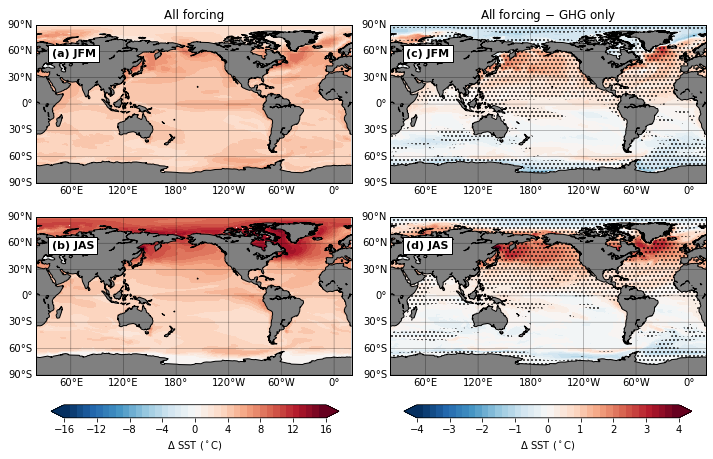

In [7]:
levels = np.linspace(-16, 16, 41)
levels2 = np.linspace(-4, 4, 41)
cblabel= '$\Delta$ SST ($^\circ$C)'
fig = plot_diff_clim_all_ttest(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg,
                         levels, levels2, cblabel)
if save_fig:
    figname = fig_root+'/CMIP6_ScenarioMIP_Map_SST.png'
    fig.savefig(figname, dpi = 300)

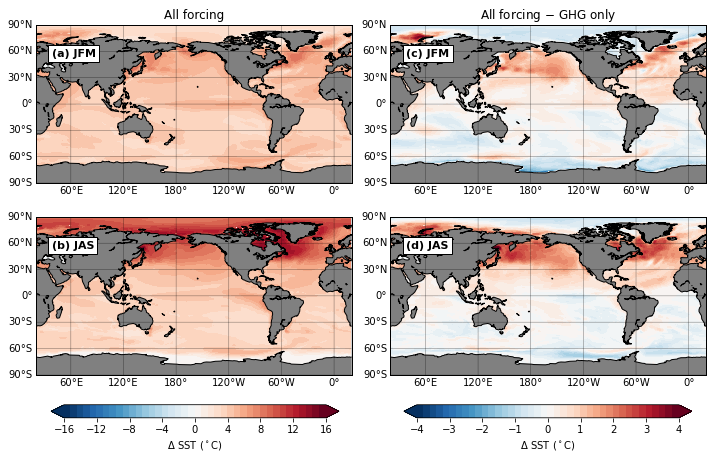

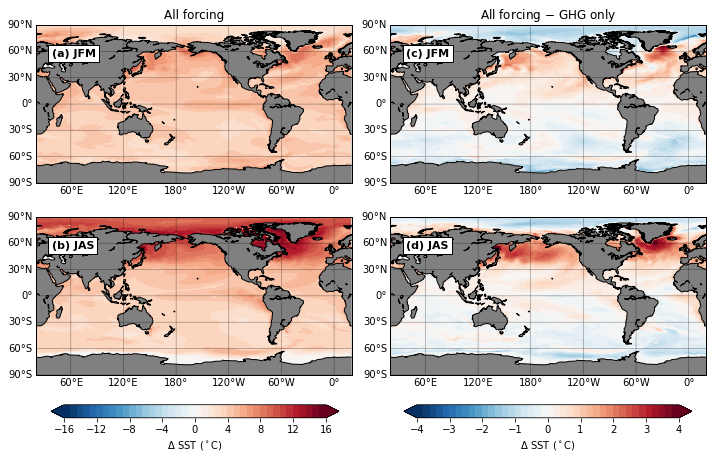

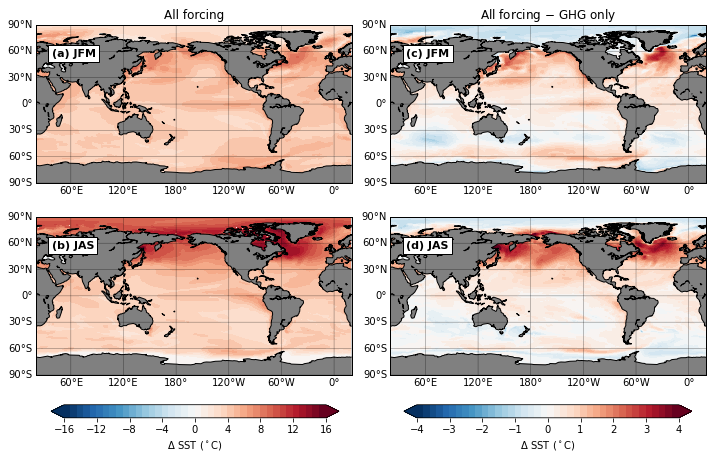

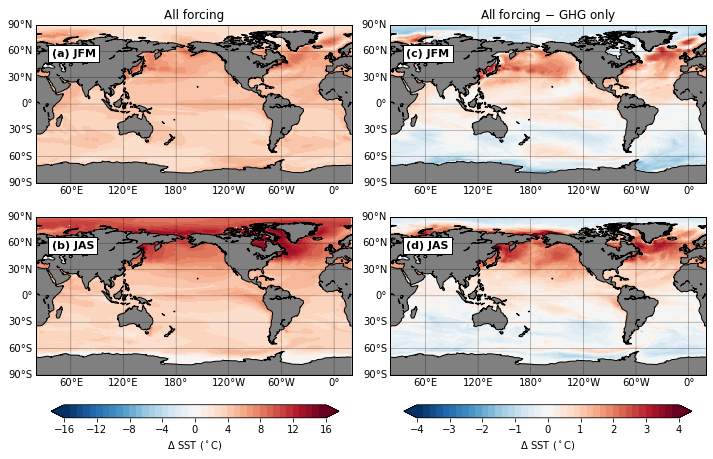

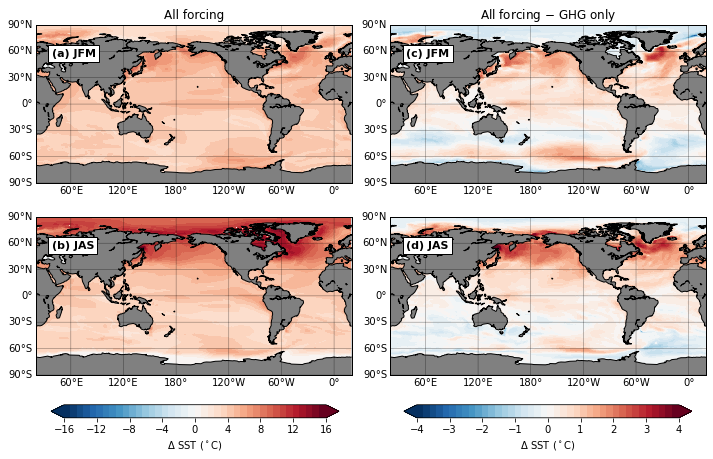

In [8]:
for i in np.arange(5):
    j = min(2,i)
    fig = plot_diff_clim_all(diff_jfm_da.isel(case=i), diff_jas_da.isel(case=i),
                             diff_jfm_da_ghg.isel(case=j), diff_jas_da_ghg.isel(case=j),
                             levels, levels2, cblabel)
    if save_fig:
        figname = fig_root+'/CMIP6_ScenarioMIP_Map_SST_C{:d}.png'.format(i)
        fig.savefig(figname, dpi = 300)

In [9]:
varname = 'timeMonthly_avg_activeTracers_salinity'
diff_jas_da, diff_jfm_da, diff_jas_da_ghg, diff_jfm_da_ghg = get_diff_clim_all(varname)

/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in greater
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in greater


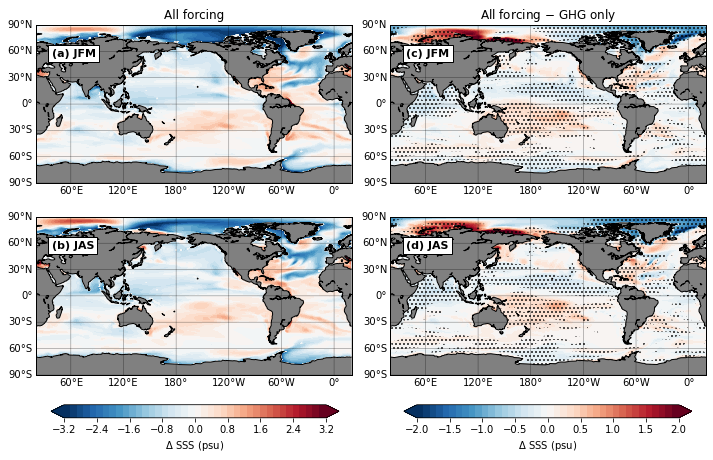

In [10]:
levels = np.linspace(-3.2, 3.2, 41)
levels2 = np.linspace(-2, 2, 41)
cblabel= '$\Delta$ SSS (psu)'
fig = plot_diff_clim_all_ttest(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg,
                         levels, levels2, cblabel)
if save_fig:
    figname = fig_root+'/CMIP6_ScenarioMIP_Map_SSS.png'
    fig.savefig(figname, dpi = 300)

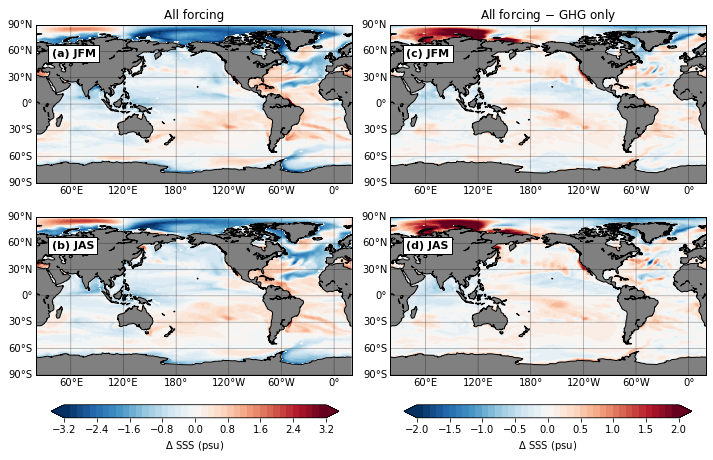

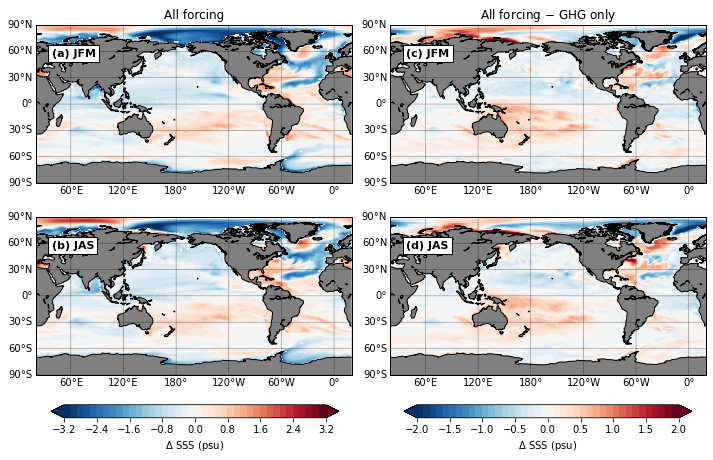

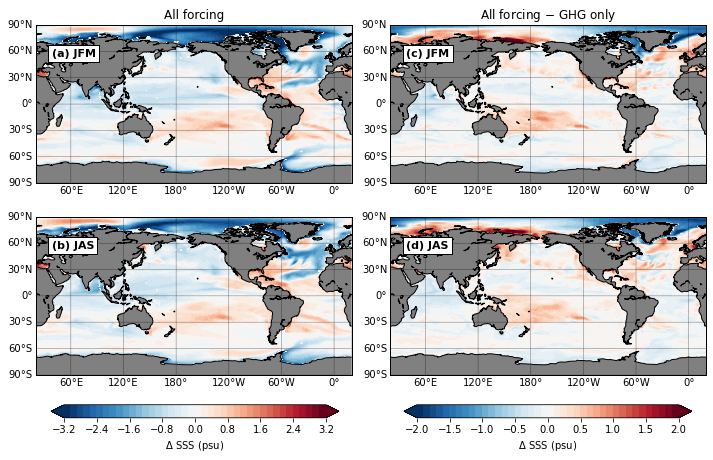

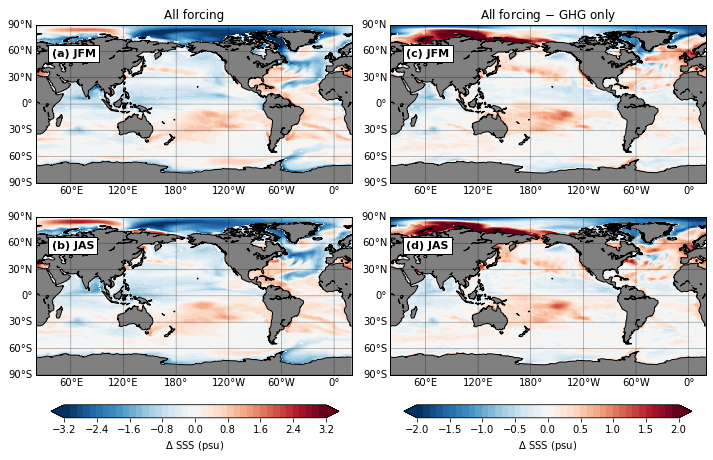

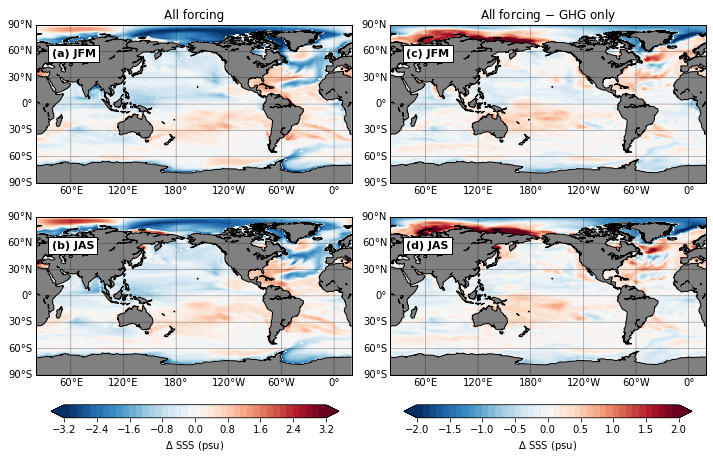

In [11]:
for i in np.arange(5):
    j = min(2,i)
    fig = plot_diff_clim_all(diff_jfm_da.isel(case=i), diff_jas_da.isel(case=i),
                             diff_jfm_da_ghg.isel(case=j), diff_jas_da_ghg.isel(case=j),
                             levels, levels2, cblabel)
    if save_fig:
        figname = fig_root+'/CMIP6_ScenarioMIP_Map_SSS_C{:d}.png'.format(i)
        fig.savefig(figname, dpi = 300)

In [12]:
varname = 'timeMonthly_avg_dThreshMLD'
diff_jas_da, diff_jfm_da, diff_jas_da_ghg, diff_jfm_da_ghg = get_diff_clim_all(varname, ndim=2)

/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in greater
/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in greater


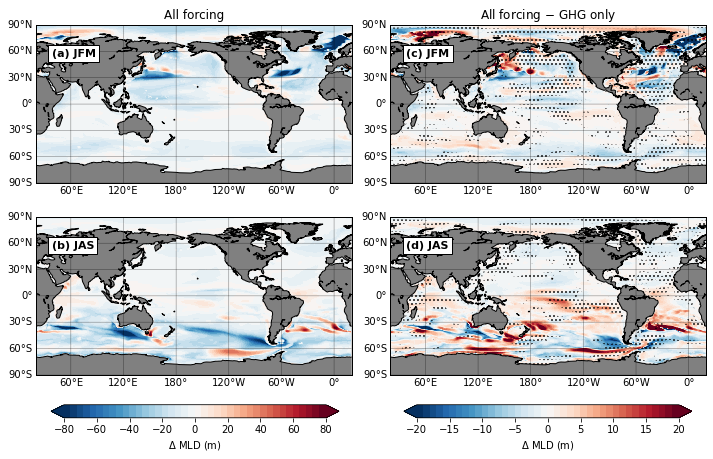

In [13]:
# levels = np.array([-200, -150, -100, -80, -60, -40, -20, -10, -5, -1,
#                    1, 5, 10, 20, 40, 60, 80, 100, 150, 200])
levels = np.linspace(-80, 80, 41)
levels2 = np.linspace(-20, 20, 41)
cblabel= '$\Delta$ MLD (m)'
fig = plot_diff_clim_all_ttest(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg,
                         levels, levels2, cblabel)
if save_fig:
    figname = fig_root+'/CMIP6_ScenarioMIP_Map_MLD.png'
    fig.savefig(figname, dpi = 300)

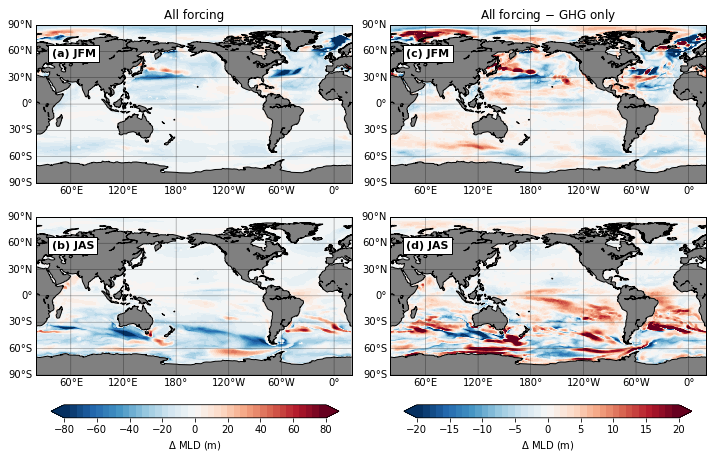

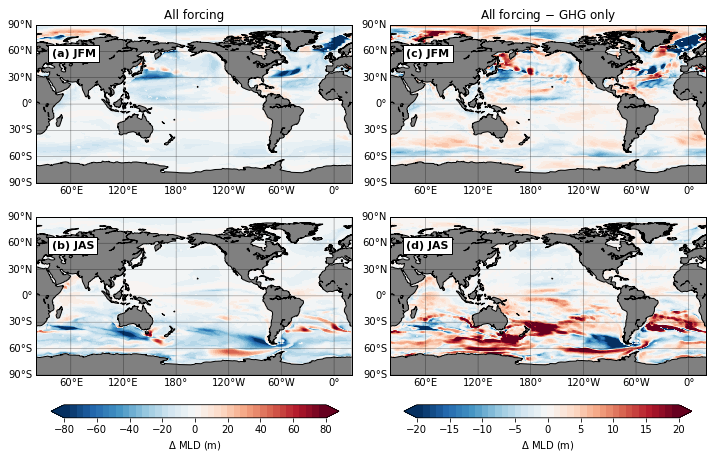

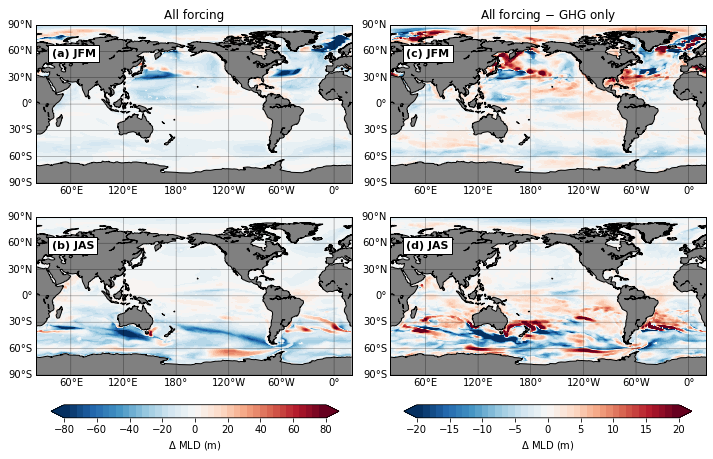

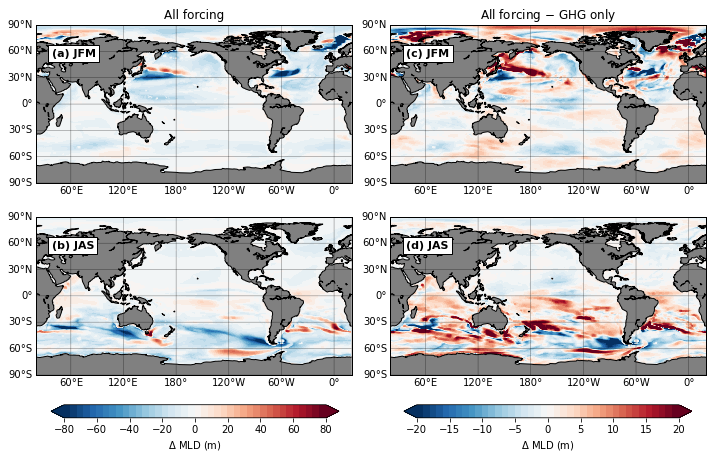

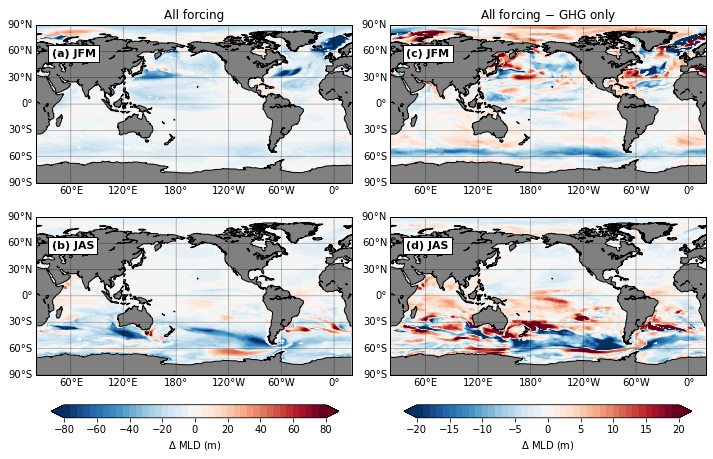

In [14]:
for i in np.arange(5):
    j = min(2,i)
    fig = plot_diff_clim_all(diff_jfm_da.isel(case=i), diff_jas_da.isel(case=i),
                             diff_jfm_da_ghg.isel(case=j), diff_jas_da_ghg.isel(case=j),
                             levels, levels2, cblabel)
    if save_fig:
        figname = fig_root+'/CMIP6_ScenarioMIP_Map_MLD_C{:d}.png'.format(i)
        fig.savefig(figname, dpi = 300)
    